In [72]:
import re
import pandas as pd

# Load the text file
with open('data/114th congress.txt', 'r', errors='ignore') as file:
    content = file.read()

# Split the content on "Picture of"
parts = re.split(r'Picture of ', content)

# Initialize an empty list to store the data
data = []

# Loop over the parts
for part in parts:
    # Split on newline to separate the name from the title
    lines = part.split('\n')
    name = lines[0].strip()
    if len(lines) > 2:
        title = lines[2].strip()
        # The party is the first character after "U.S. Representative", "U.S. Representative (Former)", "Congressional Delegate", or "U.S. Senator"
        match = re.search(r'(U\.S\. Representative|U\.S\. Representative \(Former\)|Congressional Delegate|U\.S\. Senator)\s*([A-Z])-', title)
        if match:
            party = match.group(2)
            data.append([name, party])

# Create a DataFrame
congress114 = pd.DataFrame(data, columns=['Name', 'Party'])

# Count the number of entries in the DataFrame
num_entries = len(congress114)

print(num_entries)
congress114.head(20)


547


,Name,Party
0,Ralph Abraham,R
1,Alma Adams,D
2,Robert T. Aderholt,R
3,Pete Aguilar,D
4,Rick Allen,R
5,Justin Amash,R
6,Mark Amodei,R
7,Brad Ashford,D
8,Brian Babin,R
9,Lou Barletta,R


In [73]:
congress114.to_csv('114th_Congress.csv')

In [74]:
df = pd.read_csv('data/114th_Congress.csv')

In [75]:
df['Last Name'] = df['Name'].str.split().str[-1]
df_unique_last_names = df[~df['Last Name'].duplicated(keep=False)]
party_mapping_unique = df_unique_last_names.set_index('Last Name')['Party'].to_dict()

# Read and process 'political_social_media.csv'
social_media_data = pd.read_csv('data/political_social_media.csv', encoding='ISO-8859-1')

# Extract the name from the 'label' column in 'political_social_media.csv'
social_media_data['Name'] = social_media_data['label'].str.extract(r'From: (.*?) \(', expand=False)
social_media_data['Last Name'] = social_media_data['Name'].str.split().str[-1]

# Merge the datasets
social_media_data['Party'] = social_media_data['Last Name'].map(party_mapping_unique)

# Drop NaNs from 'Party' column
social_media_data.dropna(subset=['Party'], inplace=True)

# Display the first few rows of the merged DataFrame
social_media_data.head()



,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,audience,audience:confidence,bias,bias:confidence,message,...,bioid,embed,id,label,message_gold,source,text,Name,Last Name,Party
1,766192485,False,finalized,1,8/4/15 21:20,national,1.0,partisan,1.0000,attack,...,M000355,"<blockquote class=""twitter-tweet"" width=""450"">...",3.11208E+17,From: Mitch McConnell (Senator from Kentucky),NaN,twitter,VIDEO - #Obamacare: Full of Higher Costs and ...,Mitch McConnell,McConnell,R
2,766192486,False,finalized,1,8/4/15 21:14,national,1.0,neutral,1.0000,support,...,S001180,"<blockquote class=""twitter-tweet"" width=""450"">...",3.39069E+17,From: Kurt Schrader (Representative from Oregon),NaN,twitter,Please join me today in remembering our fallen...,Kurt Schrader,Schrader,D
3,766192487,False,finalized,1,8/4/15 21:08,national,1.0,neutral,1.0000,policy,...,C000880,"<blockquote class=""twitter-tweet"" width=""450"">...",2.98528E+17,From: Michael Crapo (Senator from Idaho),NaN,twitter,RT @SenatorLeahy: 1st step toward Senate debat...,Michael Crapo,Crapo,R
4,766192488,False,finalized,1,8/4/15 21:26,national,1.0,partisan,1.0000,policy,...,U000038,"<blockquote class=""twitter-tweet"" width=""450"">...",4.07643E+17,From: Mark Udall (Senator from Colorado),NaN,twitter,.@amazon delivery #drones show need to update ...,Mark Udall,Udall,D
5,766192489,False,finalized,2,8/4/15 21:06,national,1.0,partisan,0.5216,information,...,H001069,"<blockquote class=""twitter-tweet"" width=""450"">...",4.2103E+17,From: Heidi Heitkamp (Senator from North Dakota),NaN,twitter,Called on the @USDOTFRA to release info about ...,Heidi Heitkamp,Heitkamp,D


In [76]:
social_media_data.shape

(3773, 24)

In [77]:
social_media_data.to_csv('cleaned_political_social_media.csv')

# TF-IDF

In [78]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from sklearn.model_selection import train_test_split

# Generate a list of stopwords 
nltk.download('stopwords')
stops = stopwords.words('english') + list(string.punctuation)

# Read in data
df_partisan = pd.read_csv('cleaned_political_social_media.csv')

# Convert string labels to 1 or 0 
le = LabelEncoder()
df_partisan['target'] = le.fit_transform(df_partisan['bias'])

# Examine our data
print(df_partisan.head())

# Separate features and labels 
X = df_partisan['text']
y = df_partisan['target']

# Create test and train datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state=1)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/forrestwilliams/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


   Unnamed: 0   _unit_id  _golden _unit_state  _trusted_judgments  \
0           1  766192485    False   finalized                   1   
1           2  766192486    False   finalized                   1   
2           3  766192487    False   finalized                   1   
3           4  766192488    False   finalized                   1   
4           5  766192489    False   finalized                   2   

  _last_judgment_at  audience  audience:confidence      bias  bias:confidence  \
0      8/4/15 21:20  national                  1.0  partisan           1.0000   
1      8/4/15 21:14  national                  1.0   neutral           1.0000   
2      8/4/15 21:08  national                  1.0   neutral           1.0000   
3      8/4/15 21:26  national                  1.0  partisan           1.0000   
4      8/4/15 21:06  national                  1.0  partisan           0.5216   

   ...                                              embed           id  \
0  ...  <blockquote clas

In [79]:
vectorizer = TfidfVectorizer(stop_words= stops)
vectorizer.fit(X_train)
tf_idf_train = vectorizer.transform(X_train)
tf_idf_test = vectorizer.transform(X_test)

In [80]:
classifier = RandomForestClassifier(random_state=1)
classifier.fit(tf_idf_train, y_train)

y_preds = classifier.predict(tf_idf_test)

In [81]:
y_preds

array([0, 1, 0, ..., 0, 0, 0])

In [82]:
classifier.score(tf_idf_test, y_test)

0.7503974562798092

In [83]:
from sklearn.metrics import ConfusionMatrixDisplay

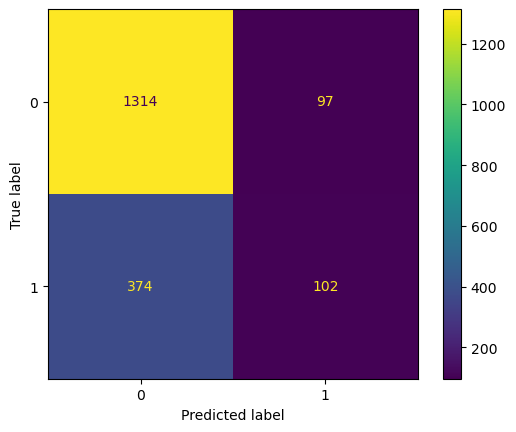

In [84]:
ConfusionMatrixDisplay.from_predictions(y_test, y_preds)

In [85]:
from sklearn.metrics import roc_curve, auc, log_loss, confusion_matrix, classification_report, ConfusionMatrixDisplay

In [86]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.78      0.93      0.85      1411
           1       0.51      0.21      0.30       476

    accuracy                           0.75      1887
   macro avg       0.65      0.57      0.58      1887
weighted avg       0.71      0.75      0.71      1887



In [87]:
from sklearn.feature_extraction.text import CountVectorizer
ct_vectorizer = CountVectorizer()
ct_vectorizer.fit(X_train)
X_tr_vec = ct_vectorizer.transform(X_train)
X_te_vec = ct_vectorizer.transform(X_test)

In [88]:
rfc = RandomForestClassifier()
rfc.fit(X_tr_vec, y_train)

RandomForestClassifier()

In [89]:
rfc.score(X_te_vec, y_test)

0.7562268150503445

In [90]:
y_preds_ct = rfc.predict(X_te_vec)

In [91]:
print(classification_report(y_test, y_preds_ct))

              precision    recall  f1-score   support

           0       0.76      0.97      0.86      1411
           1       0.59      0.11      0.19       476

    accuracy                           0.76      1887
   macro avg       0.68      0.54      0.52      1887
weighted avg       0.72      0.76      0.69      1887



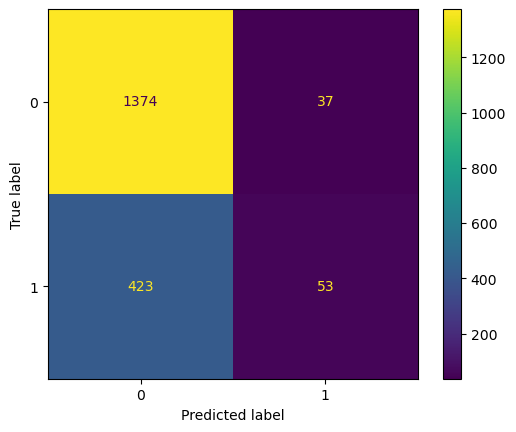

In [92]:
ConfusionMatrixDisplay.from_predictions(y_test, y_preds_ct)

In [93]:
# standard packages for data analysis and NLP

import numpy as np
import pandas as pd
from copy import deepcopy

#visualization packages
import seaborn as sns
import matplotlib.pyplot as plt

# NLP modules we will use for text normalization
import re #regex 
import nltk # the natural language toolkit
from nltk.tokenize import word_tokenize
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import pos_tag

# feature construction
from sklearn.feature_extraction.text import TfidfVectorizer #use this to create BoW matrix

In [94]:
# additional argument sets cut off minimum length for tokenized text at which function converts to null string.
def process_tweet(tweet_text, min_length):
    
    # get common stop words that we'll remove during tokenization/text normalization
    stop_words = stopwords.words('english')

    #initialize lemmatizer
    wnl = WordNetLemmatizer()

    # helper function to change nltk's part of speech tagging to a wordnet format.
    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:         
            return None
   

    # lower case everything
    tweet_lower = tweet_text.lower()

    #remove mentions, hashtags, and urls, strip whitspace and breaks
    tweet_lower = re.sub(r"@[a-z0-9_]+|#[a-z0-9_]+|http\S+", "", tweet_lower).strip().replace("\r", "").replace("\n", "").replace("\t", "")
    
    
    # remove stop words and punctuations 
    tweet_norm = [x for x in word_tokenize(tweet_lower) if ((x.isalpha()) & (x not in stop_words)) ]

    #  POS detection on the result will be important in telling Wordnet's lemmatizer how to lemmatize
    
    # creates list of tuples with tokens and POS tags in wordnet format
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(tweet_norm))) 

    # now we are going to have a cutoff here. any tokenized cocument with length < min length will be removed from corpus
    if len(wordnet_tagged) <= min_length:
        return ''
    else:
         # rejoins lemmatized sentence 
        tweet_norm = " ".join([wnl.lemmatize(x[0], x[1]) for x in wordnet_tagged if x[1] is not None])
        return tweet_norm



## Ask Brendan about the args

In [95]:
# anything with no of tokens <= 10 is likely junk. apply has additional args parameter to pass in function arguments.
df_partisan['text'] = df_partisan['text'].apply(process_tweet, args = [10])

#our processing created some empty documents, so we should drop these.

In [96]:
# some documents are short enough cleaning may have wiped it out.
df_partisan_new = df_partisan[df_partisan['text'] != '']

In [97]:
df_partisan_new.shape

(1970, 26)

In [98]:
X_new= df_partisan_new['text']
y_new= df_partisan_new['target']

In [99]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size = 0.5, random_state=1)

In [100]:
tfidf_vec = TfidfVectorizer()
tfidf_vec.fit(X_train_new)
tf_idf_train = tfidf_vec.transform(X_train_new)
tf_idf_test = tfidf_vec.transform(X_test_new)

In [102]:
rfc_tfidf = RandomForestClassifier(random_state=1)
rfc_tfidf.fit(tf_idf_train, y_train_new)

y_preds = rfc_tfidf.predict(tf_idf_test)

In [104]:
rfc_tfidf.score(tf_idf_test, y_test_new)

0.7340101522842639

In [106]:
print(classification_report(y_test_new, y_preds))

              precision    recall  f1-score   support

           0       0.75      0.96      0.84       721
           1       0.52      0.11      0.18       264

    accuracy                           0.73       985
   macro avg       0.63      0.54      0.51       985
weighted avg       0.69      0.73      0.66       985



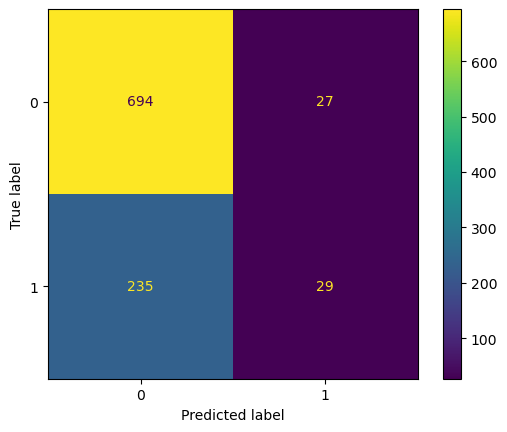

In [109]:
ConfusionMatrixDisplay.from_predictions(y_test_new, y_preds)

# pipelines

In [ ]:
unupervised on sentiment for the tweetset I have
covid sentiment